# Stock Chart Pattern Recognition with Deep Learning
## CRISP-DM Methodology

🟦 Phase 1: Environment Setup

✅ Cell 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML / DL
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,SpatialDropout1D,BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

# Cassandra
from cassandra.cluster import Cluster

# Seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


🟦 Phase 2: Data Understanding

✅ Cell 2: Connect to Cassandra & Fetch Data

In [2]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
# 1. รายชื่อหุ้นที่ต้องการดึงจาก Cassandra
stock_list = ['PTT', 'ADVANC', 'TRUBB', 'TRUE', '3BBIF', 'BANPU', 'CPALL']

# 2. ตั้งค่า Keyspace
session.set_keyspace('stock_data')

all_stock_data = []

print("เริ่มดึงข้อมูลจาก Cassandra...")

for symbol in stock_list:
    # Query ข้อมูลรายตัว โดยกรองจาก symbol (สมมติว่าใน Table มีคอลัมน์ symbol)
    # หาก Table แยกตาม symbol ให้ปรับ Query เป็น FROM candlestick_data_{symbol} ตามโครงสร้างของคุณ
    query = f"SELECT time, open_price, high_price, low_price, close_price, volume FROM candlestick_data WHERE symbol = '{symbol}'"
    
    try:
        rows = session.execute(query)
        df_temp = pd.DataFrame(list(rows))
        
        if not df_temp.empty:
            # เพิ่มคอลัมน์ symbol เพื่อระบุว่าข้อมูลนี้ของหุ้นตัวไหน (สำคัญมากสำหรับตอน Scale และ Label)
            df_temp['symbol'] = symbol
            # เรียงลำดับเวลา
            df_temp = df_temp.sort_values('time').reset_index(drop=True)
            all_stock_data.append(df_temp)
            print(f"✅ ดึงข้อมูล {symbol} สำเร็จ: {len(df_temp)} แถว")
        else:
            print(f"⚠️ ไม่พบข้อมูลสำหรับ {symbol}")
            
    except Exception as e:
        print(f"❌ Error ในการดึง {symbol}: {e}")

# 3. รวมข้อมูลหุ้นทุกตัวเข้าด้วยกัน
if all_stock_data:
    df = pd.concat(all_stock_data, axis=0).reset_index(drop=True)
    print(f"\n--- สรุปการดึงข้อมูล ---")
    print(f"รวมข้อมูลทั้งหมด: {len(df)} แถว จากหุ้น {len(all_stock_data)} ตัว")
else:
    print("ไม่มีข้อมูลที่ถูกดึงมาได้เลย")

# แสดงตัวอย่างข้อมูล
df.head()


เริ่มดึงข้อมูลจาก Cassandra...
✅ ดึงข้อมูล PTT สำเร็จ: 729 แถว
✅ ดึงข้อมูล ADVANC สำเร็จ: 729 แถว
⚠️ ไม่พบข้อมูลสำหรับ TRUBB
⚠️ ไม่พบข้อมูลสำหรับ TRUE
✅ ดึงข้อมูล 3BBIF สำเร็จ: 729 แถว
✅ ดึงข้อมูล BANPU สำเร็จ: 729 แถว
✅ ดึงข้อมูล CPALL สำเร็จ: 729 แถว

--- สรุปการดึงข้อมูล ---
รวมข้อมูลทั้งหมด: 3645 แถว จากหุ้น 5 ตัว


,time,open_price,high_price,low_price,close_price,volume,symbol
0,2023-01-09,32.75,33.25,32.75,33.00,48837692,PTT
1,2023-01-10,33.25,33.25,32.75,33.25,39540053,PTT
2,2023-01-11,33.25,33.50,33.00,33.50,45435296,PTT
3,2023-01-12,33.50,33.75,33.25,33.75,41018316,PTT
4,2023-01-13,33.75,34.00,33.25,33.75,71005807,PTT


✅ Cell 3: EDA

In [3]:
# ✅ Cell 3: EDA & Basic Cleaning
print(f"จำนวนข้อมูลก่อนคลีน: {len(df)}")
df = df.dropna() # ลบแถวที่มีค่าว่าง
df = df.drop_duplicates(subset=['time', 'symbol']) # ลบข้อมูลซ้ำถ้ามี
df = df.sort_values(['symbol', 'time']).reset_index(drop=True)
print(f"จำนวนข้อมูลหลังคลีน: {len(df)}")

# ดูจำนวนข้อมูลรายคลาส
print("\nจำนวนข้อมูลต่อหุ้น:")
print(df['symbol'].value_counts())

จำนวนข้อมูลก่อนคลีน: 3645
จำนวนข้อมูลหลังคลีน: 3645

จำนวนข้อมูลต่อหุ้น:
symbol
3BBIF     729
ADVANC    729
BANPU     729
CPALL     729
PTT       729
Name: count, dtype: int64


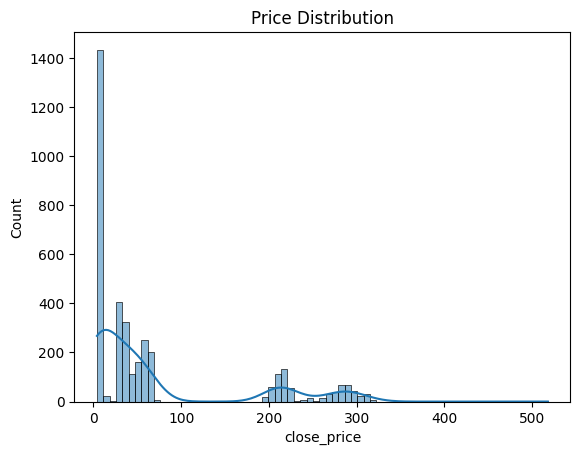

In [4]:
# Distribution
sns.histplot(df['close_price'], kde=True)
plt.title("Price Distribution")
plt.show()

In [5]:
# Missing Values
print(df.isnull().sum())

time           0
open_price     0
high_price     0
low_price      0
close_price    0
volume         0
symbol         0
dtype: int64


🟦 Phase 3: Data Preparation

✅ Cell 4: Scale Data (features only)

In [6]:
# ✅ Cell 4: Scale Data (Group by Symbol)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# สร้าง Column สำหรับเก็บค่าที่ Scale แล้ว
features = ['open_price', 'high_price', 'low_price', 'close_price', 'volume']
all_scaled_list = []

for symbol in df['symbol'].unique():
    subset = df[df['symbol'] == symbol][features].values
    scaled_subset = scaler.fit_transform(subset)
    all_scaled_list.append(scaled_subset)

# รวมเป็นก้อนเดียวเพื่อเข้า Model
all_scaled = np.vstack(all_scaled_list)
print("Shape ของข้อมูลที่ Scale แล้ว:", all_scaled.shape)

Shape ของข้อมูลที่ Scale แล้ว: (3645, 5)


✅ Cell 5: H&S Labeling Logic (จริง ไม่สุ่ม)

In [7]:
def detect_peaks_troughs(prices):
    peaks, troughs = [], []
    for i in range(1, len(prices)-1):
        if prices[i] > prices[i-1] and prices[i] > prices[i+1]:
            peaks.append(i)
        if prices[i] < prices[i-1] and prices[i] < prices[i+1]:
            troughs.append(i)
    return peaks, troughs


def label_hs_real(prices, tol=0.03):
    labels = np.zeros(len(prices))
    peaks, troughs = detect_peaks_troughs(prices)

    for i in range(len(peaks)-2):
        p1, p2, p3 = peaks[i:i+3]

        # Head must be highest
        if prices[p2] <= prices[p1] or prices[p2] <= prices[p3]:
            continue

        # Shoulder symmetry
        if abs(prices[p1] - prices[p3]) / prices[p2] > tol:
            continue

        # Troughs
        t1 = [t for t in troughs if p1 < t < p2]
        t2 = [t for t in troughs if p2 < t < p3]
        if not t1 or not t2:
            continue

        neckline = (prices[min(t1)] + prices[min(t2)]) / 2

        # Confirmation
        if p3+1 < len(prices) and prices[p3+1] < neckline:
            labels[p1] = 1
            labels[p2] = 2
            labels[p3] = 3

    return labels


df['hs_label'] = label_hs_real(df['close_price'].values)

print(df['hs_label'].value_counts())


hs_label
0.0    3568
1.0      26
2.0      26
3.0      25
Name: count, dtype: int64


✅ Cell 6: Sliding Window + Prepare Labels

In [8]:
# ✅ Cell 6: Sliding Window + Prepare Labels
from sklearn.model_selection import train_test_split

def create_windows(X, y, window_size=60, stride=1):
    Xs, ys = [], []
    for i in range(0, len(X) - window_size, stride):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size//2])
    return np.array(Xs), np.array(ys)

# ✅ Cell 6: เพิ่มจำนวน Data Points ด้วยการลด Stride
WINDOW = 60
STRIDE = 1  # ⭐ ปรับจาก 5 เป็น 1 เพื่อเพิ่มจำนวน Windows

X, y = create_windows(
    all_scaled,
    df['hs_label'].values,
    WINDOW,
    STRIDE
)

# ตรวจสอบจำนวนก่อนแบ่งอีกครั้ง (ควรจะเพิ่มขึ้นหลายเท่าตัว)
unique, counts = np.unique(y, return_counts=True)
print("จำนวน Windows ทั้งหมดแยกตามคลาส:", dict(zip(unique, counts)))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,      
    random_state=42,
    shuffle=True 
)

print("\n--- หลังปรับ STRIDE ---")
print("Train distribution:\n", pd.Series(y_train).value_counts())
print("Test distribution:\n", pd.Series(y_test).value_counts())

จำนวน Windows ทั้งหมดแยกตามคลาส: {np.float64(0.0): np.int64(3508), np.float64(1.0): np.int64(26), np.float64(2.0): np.int64(26), np.float64(3.0): np.int64(25)}

--- หลังปรับ STRIDE ---
Train distribution:
 0.0    2806
2.0      21
1.0      21
3.0      20
Name: count, dtype: int64
Test distribution:
 0.0    702
3.0      5
2.0      5
1.0      5
Name: count, dtype: int64


🟦 Phase 4: Modeling

✅ Cell 7: Hybrid CNN-LSTM Model

In [9]:
# Cell 7: ปรับปรุงโครงสร้าง


inputs = Input(shape=(WINDOW, X.shape[2]))

x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = SpatialDropout1D(0.2)(x) # ป้องกันการจำจุดราคาที่เฉพาะเจาะจงเกินไป

x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.4)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

✅ Cell 8: Model Training (แก้ตรงนี้)

In [10]:
# 1. คำนวณน้ำหนักคลาส (Class Weights) 
# เพื่อบีบให้โมเดลสนใจคลาส 1, 2, 3 ที่มีข้อมูลน้อยมาก
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))
print("Class Weights Calculated:", class_weight_dict)

# 2. ตั้งค่า Callbacks เพื่อคุมความเสถียรของกราฟ
callbacks = [
    # หยุดเทรนถ้า Val Loss ไม่ดีขึ้น 12 รอบ ป้องกัน Overfitting
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    
    # บันทึกน้ำหนักที่ดีที่สุดไว้
    ModelCheckpoint("best_hs_model.keras", save_best_only=True, monitor='val_loss'),
    
    # ลด Learning Rate เมื่อการเรียนรู้เริ่มนิ่ง
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# 3. เริ่มการเทรน
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,   # สำคัญมาก: ช่วยแก้ปัญหา Imbalance
    callbacks=callbacks,
    verbose=1
)

Class Weights Calculated: {0: np.float64(0.25552387740555954), 1: np.float64(34.142857142857146), 2: np.float64(34.142857142857146), 3: np.float64(35.85)}
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4219 - loss: 1.4863 - val_accuracy: 0.3738 - val_loss: 1.3914 - learning_rate: 1.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4418 - loss: 1.4007 - val_accuracy: 0.3612 - val_loss: 1.3936 - learning_rate: 1.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4209 - loss: 1.4485 - val_accuracy: 0.3933 - val_loss: 1.3901 - learning_rate: 1.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3982 - loss: 1.4312 - val_accuracy: 0.3096 - val_loss: 1.3899 - learning_rate: 1.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3821 - loss: 1.3356 - val_accuracy: 0.3222 - val_loss: 1.3823 - learning_rate: 1.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3783 

🟦 Phase 5: Evaluation

🔹 Cell 9: Training Health

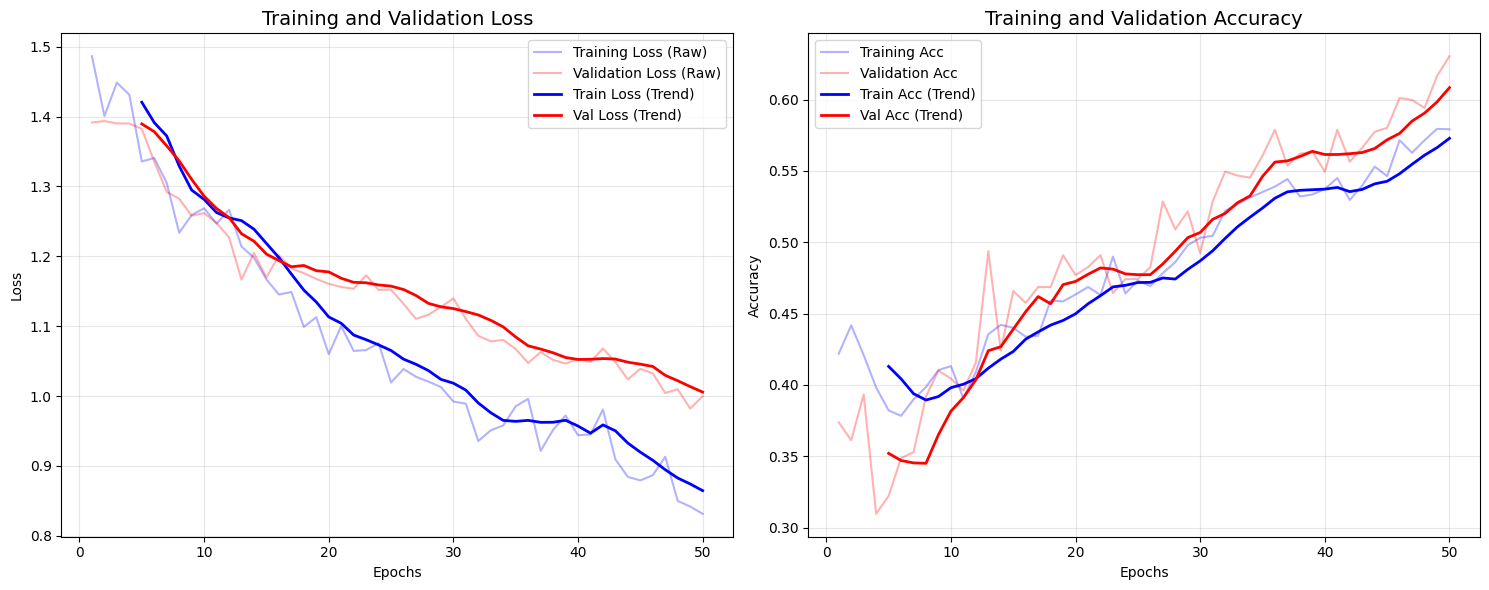

In [11]:
def plot_learning_curves(history):
    """
    ฟังก์ชันสำหรับพล็อต Loss และ Accuracy ให้ดูง่ายและวิเคราะห์ปัญหาได้ชัดเจน
    """
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 6))

    # --- Plot 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', alpha=0.3, label='Training Loss (Raw)')
    plt.plot(epochs, val_loss, 'r-', alpha=0.3, label='Validation Loss (Raw)')
    
    # เพิ่ม Moving Average เพื่อดู Trend (กรณี Loss ผันผวน)
    if len(loss) > 5:
        plt.plot(epochs[4:], pd.Series(loss).rolling(5).mean()[4:], "b-", linewidth=2, label='Train Loss (Trend)')
        plt.plot(epochs[4:], pd.Series(val_loss).rolling(5).mean()[4:], "r-", linewidth=2, label='Val Loss (Trend)')

    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # --- Plot 2: Accuracy ---
    if acc:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, 'b-', alpha=0.3, label='Training Acc')
        plt.plot(epochs, val_acc, 'r-', alpha=0.3, label='Validation Acc')
        if len(acc) > 5:
            plt.plot(epochs[4:], pd.Series(acc).rolling(5).mean()[4:], "b-", linewidth=2, label='Train Acc (Trend)')
            plt.plot(epochs[4:], pd.Series(val_acc).rolling(5).mean()[4:], "r-", linewidth=2, label='Val Acc (Trend)')
            
        plt.title('Training and Validation Accuracy', fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# เรียกใช้งาน
plot_learning_curves(history)

✅ Cell 10: Confusion Matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
y_test distribution : (array([0., 1., 2., 3.]), array([702,   5,   5,   5]))
y_pred distribution : (array([0, 1, 2, 3]), array([452,  74,  83, 108]))


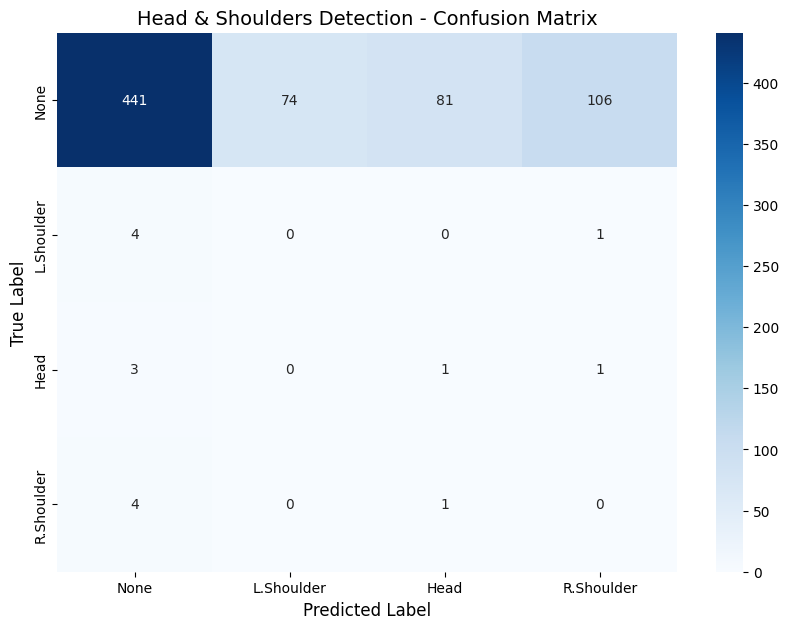


Detailed Classification Report (All Classes)
              precision    recall  f1-score   support

        None       0.98      0.63      0.76       702
  L.Shoulder       0.00      0.00      0.00         5
        Head       0.01      0.20      0.02         5
  R.Shoulder       0.00      0.00      0.00         5

    accuracy                           0.62       717
   macro avg       0.25      0.21      0.20       717
weighted avg       0.96      0.62      0.75       717



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ===============================
# 1. Predict
# ===============================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# ===============================
# 2. Define classes
# ===============================
labels = [0, 1, 2, 3]
target_names = ['None', 'L.Shoulder', 'Head', 'R.Shoulder']

# ===============================
# 3. Debug: ตรวจ distribution (สำคัญมาก)
# ===============================
print("y_test distribution :", np.unique(y_test, return_counts=True))
print("y_pred distribution :", np.unique(y_pred, return_counts=True))

# ===============================
# 4. Confusion Matrix (Fix class mismatch)
# ===============================
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Head & Shoulders Detection - Confusion Matrix', fontsize=14)
plt.show()

# ===============================
# 5. Classification Report (Fix ERROR)
# ===============================
print("\n" + "="*70)
print("Detailed Classification Report (All Classes)")
print("="*70)

print(classification_report(
    y_test,
    y_pred,
    labels=labels,                 # ⭐ สำคัญที่สุด
    target_names=target_names,
    zero_division=0
))


✅ Cell 11: Confidence Threshold (คัดกรองความเชื่อมั่น)

In [13]:
# ==========================================
# Cell 11: Confidence Threshold Filtering
# ==========================================
import numpy as np
import pandas as pd

# 1. ตั้งค่าความมั่นใจ (0.0 - 1.0) 
# เริ่มต้นแนะนำที่ 0.70 - 0.85 เพื่อลดสัญญาณหลอก
CONFIDENCE_THRESHOLD = 0.80 

# 2. ทำนายผลเป็นค่า Probability
y_pred_probs = model.predict(X_test)

# 3. สร้าง List ใหม่ที่เก็บเฉพาะค่าที่ผ่านเกณฑ์
y_refined = []
for prob in y_pred_probs:
    max_val = np.max(prob)      # ค่าความมั่นใจสูงสุดในบรรดา 4 คลาส
    pred_class = np.argmax(prob) # คลาสที่โมเดลเลือก
    
    # ถ้าความมั่นใจไม่ถึงเกณฑ์ ให้ปัดเป็นคลาส 0 (None) ทันที
    if max_val >= CONFIDENCE_THRESHOLD:
        y_refined.append(pred_class)
    else:
        y_refined.append(0)

y_refined = np.array(y_refined)

# แสดงสถิติหลังการกรอง
unique, counts = np.unique(y_refined, return_counts=True)
print(f"ผลการทำนายหลังกรองด้วย Threshold {CONFIDENCE_THRESHOLD}:")
print(dict(zip(['None', 'L.Shoulder', 'Head', 'R.Shoulder'], counts.tolist() if len(counts)==4 else counts)))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ผลการทำนายหลังกรองด้วย Threshold 0.8:
{'None': np.int64(717)}


✅ Cell 12: Sequence Verification (ตรวจสอบรูปทรงตามลำดับ)

In [ ]:
# ==========================================
# Cell 12: Sequence Verification Logic
# ==========================================

def verify_sequence_flexible(preds, gap=20):
    """
    ตรวจสอบการเรียงลำดับ 1 -> 2 -> 3 โดยยอมให้มีระยะห่าง (gap) ระหว่างกัน
    """
    found_patterns = []
    n = len(preds)
    
    for i in range(n - gap*2):
        if preds[i] == 1: # 1. พบไหล่ซ้าย (L.Shoulder)
            # 2. ค้นหาหัว (Head) ในระยะถัดไปไม่เกิน gap
            for j in range(i + 1, min(i + gap, n)):
                if preds[j] == 2:
                    # 3. ค้นหาไหล่ขวา (R.Shoulder) ในระยะถัดไปไม่เกิน gap
                    for k in range(j + 1, min(j + gap, n)):
                        if preds[k] == 3:
                            found_patterns.append({
                                'L_idx': i,
                                'H_idx': j,
                                'R_idx': k
                            })
                            break # เจอครบชุดแล้ว ออกจาก Loop ใน
                    if found_patterns and found_patterns[-1]['H_idx'] == j:
                        break
    return found_patterns

# รันการตรวจสอบลำดับ
# ปรับ gap ตามความเหมาะสมของ Timeframe (เช่น 15-30 สำหรับรายวัน)
final_signals = verify_sequence_flexible(y_refined, gap=25)

print(f"--- สรุปผลการคัดกรองชั้นสุดท้าย ---")
print(f"พบรูปแบบ Head & Shoulders ที่สมบูรณ์: {len(final_signals)} ชุด")

final_signals = verify_sequence_flexible(y_refined, gap=60) # เพิ่ม gap เป็น 60

if len(final_signals) == 0:
    print("ยังไม่เจอ Pattern แบบครบชุด... กำลังลองค้นหาเฉพาะ 'หัว (Head)' ที่มั่นใจสูง:")
    heads = np.where(y_refined == 2)[0]
    print(f"พบจุดที่เป็น 'หัว' ทั้งหมด {len(heads)} จุด")


--- สรุปผลการคัดกรองชั้นสุดท้าย ---
พบรูปแบบ Head & Shoulders ที่สมบูรณ์: 0 ชุด


✅ Cell 12: Visualization Dashboard (พื้นฐาน)

In [15]:
import matplotlib.pyplot as plt

def plot_hs_dashboard(signals, X_data, num_to_show=3):
    """
    ฟังก์ชันสำหรับแสดงผลลัพธ์การตรวจจับบนกราฟราคา
    """
    if not signals:
        print("❌ ไม่พบสัญญาณที่สมบูรณ์ให้แสดงผล")
        return

    # เลือกตัวอย่างสัญญาณมาแสดงผล
    to_plot = signals[:num_to_show]
    
    plt.figure(figsize=(15, 5 * len(to_plot)))

    for i, sig in enumerate(to_plot):
        plt.subplot(len(to_plot), 1, i+1)
        
        # ดึงข้อมูล Windows ของไหล่ซ้าย, หัว, และไหล่ขวา
        # ใช้ราคา Close (สมมติว่าเป็น Index ที่ 3 ใน Features ของคุณ)
        l_shoulder_price = X_data[sig['L_idx']][:, 3]
        head_price = X_data[sig['H_idx']][:, 3]
        r_shoulder_price = X_data[sig['R_idx']][:, 3]
        
        # ต่อข้อมูลเพื่อดูความต่อเนื่อง (เลือกเฉพาะช่วงที่เกิด Pattern)
        # หมายเหตุ: นี่เป็นการแสดงผลเชิงเปรียบเทียบลักษณะ Windows
        combined_view = np.concatenate([l_shoulder_price, head_price, r_shoulder_price])
        
        plt.plot(combined_view, color='dodgerblue', linewidth=2, label='Price Action')
        
        # มาร์คจุดสำคัญ
        plt.axvline(x=30, color='orange', linestyle='--', label='L. Shoulder Zone')
        plt.axvline(x=90, color='red', linestyle='--', label='Head Zone')
        plt.axvline(x=150, color='orange', linestyle='--', label='R. Shoulder Zone')
        
        plt.title(f"H&S Detection Match #{i+1} | Confidence Gated", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# รัน Dashboard
plot_hs_dashboard(final_signals, X_test)


❌ ไม่พบสัญญาณที่สมบูรณ์ให้แสดงผล
